# Classification using Attention-based Deep Multiple Instance Learning (MIL).

**Author:** [Pierre Samaha & Loris Meggy](https://www.linkedin.com/in/pierre-samaha/)<br>
**Date created:** 2023/01/24<br>
**Last modified:** 2023/01/27<br>
**Description:** MIL approach for classification

## Introduction

### What is Multiple Instance Learning (MIL)?

Usually, with supervised learning algorithms, the learner receives labels for a set of
instances. In the case of MIL, the learner receives labels for a set of bags, each of which
contains a set of instances. The bag is labeled positive if it contains at least
one positive instance, and negative if it does not contain any.

### Business case: 

The goal is to assist with an automatic detection of breast cancer 

Almost 340 patients. That's a small number compared to the expected number of patients one would like to analyse with our algorithm after deployment. Consequently overfitting to this specific patient distribution is very likely and we need to take care about the generalization performance of our model.


Therefore, the goals are to:

1. Create an algorithm to identify cancer in small image patches taken from larger digital pathology scans.
2. Find out which instances within the bag caused a position class label
prediction.


## Setup

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.preprocessing import Normalizer

plt.style.use("ggplot")

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

# Load data

In [ ]:
# put your own path to the data root directory (see example in `Data architecture` section)
data_dir = Path("/content/drive/My Drive/Détection PIK3CA dans le cancer du sein/challenge_ens_2023_small")

# load the training and testing data sets
train_features_dir = data_dir / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "moco_features"
df_train = pd.read_csv(data_dir  / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir  / "supplementary_data" / "test_metadata.csv")

# concatenate y_train and df_train
y_train = pd.read_csv(data_dir  / "train_output.csv")
df_train = df_train.merge(y_train, on="Sample ID")

print(f"Training data dimensions: {df_train.shape}")  # (344, 4)
df_train.head()

Training data dimensions: (344, 4)


,Sample ID,Patient ID,Center ID,Target
0,ID_001.npy,P_001,C_1,0
1,ID_002.npy,P_002,C_2,1
2,ID_005.npy,P_005,C_5,0
3,ID_006.npy,P_006,C_5,0
4,ID_007.npy,P_007,C_2,1


In [ ]:
X_train = []
y_train = []
centers_train = []
patients_train = []
coordinates = []

for sample, label, center, patient in tqdm(
    df_train[["Sample ID", "Target", "Center ID", "Patient ID"]].values
):
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(train_features_dir / sample)
    # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
    # and the MoCo V2 features
    coordinate, features = _features[:, :3], _features[:, :]  # Ks

    features1= np.insert(features,0,int(center[2]), axis=1)
    X_train.append(features1)
    y_train.append(label)
    # coordinates.append(coordinate)
    centers_train.append(center)
    # patients_train.append(patient)

# convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
# centers_train = np.array(centers_train)
# patients_train = np.array(patients_train)

100%|██████████| 344/344 [00:18<00:00, 18.65it/s]


In [ ]:
X_train.shape

(344, 1000, 2052)

In [ ]:
X_train=X_train.reshape((344*1000,2052))

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train) 

In [ ]:
X_train=X_train.reshape((344,1000,2052))

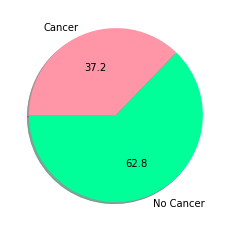

<Figure size 1152x1152 with 0 Axes>

In [ ]:
labels_count = pd.DataFrame(y_train).value_counts()

%matplotlib inline
plt.pie(labels_count, labels=['No Cancer', 'Cancer'], startangle=180, 
        autopct='%1.1f', colors=['#00ff99','#FF96A7'], shadow=True)
plt.figure(figsize=(16,16))
plt.show()

# Create dataset

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=23)
del X_train
# x_train, x_test1, y_train, y_test1 = train_test_split(x_train, y_train, test_size=0.0, random_state=20)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
print(np.count_nonzero(y_test == 0))

(340, 1000, 2052)
(4, 1000, 2052)
(340,)
(4,)
3


In [ ]:
x_train = list(np.einsum("ij...->ji...", x_train))
x_test = list(np.einsum("ij...->ji...", x_test))
# x_test1 = list(np.einsum("ij...->ji...", x_test1))
# y_test1 = y_test1[:, np.newaxis]
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]

## Create the model

We will now build the attention layer, prepare some utilities, then build and train the
entire model.

### Attention operator implementation

The output size of this layer is decided by the size of a single bag.

The attention mechanism uses a weighted average of instances in a bag, in which the sum
of the weights must equal to 1 (invariant of the bag size).

The weight matrices (parameters) are **w** and **v**. To include positive and negative
values, hyperbolic tangent element-wise non-linearity is utilized.

A **Gated attention mechanism** can be used to deal with complex relations. Another weight
matrix, **u**, is added to the computation.
A sigmoid non-linearity is used to overcome approximately linear behavior for *x* ∈ [−1, 1]
by hyperbolic tangent non-linearity.

In [ ]:
POSITIVE_CLASS = 1
BAG_COUNT = x_train[0].shape[0]
VAL_BAG_COUNT = x_test[0].shape[0]
BAG_SIZE = len(x_train)
ENSEMBLE_AVG_COUNT = 1

In [ ]:
class MILAttentionLayer(layers.Layer):
    """Implementation of the attention-based Deep MIL layer.

    Args:
      weight_params_dim: Positive Integer. Dimension of the weight matrix.
      kernel_initializer: Initializer for the `kernel` matrix.
      kernel_regularizer: Regularizer function applied to the `kernel` matrix.
      use_gated: Boolean, whether or not to use the gated mechanism.

    Returns:
      List of 2D tensors with BAG_SIZE length.
      The tensors are the attention scores after softmax with shape `(batch_size, 1)`.
    """

    def __init__(
        self,
        weight_params_dim,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        use_gated=False,
        **kwargs,
    ):

        super().__init__(**kwargs)

        self.weight_params_dim = weight_params_dim
        self.use_gated = use_gated

        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

        self.v_init = self.kernel_initializer
        self.w_init = self.kernel_initializer
        self.u_init = self.kernel_initializer

        self.v_regularizer = self.kernel_regularizer
        self.w_regularizer = self.kernel_regularizer
        self.u_regularizer = self.kernel_regularizer

    def build(self, input_shape):

        # Input shape.
        # List of 2D tensors with shape: (batch_size, input_dim).
        input_dim = input_shape[0][1]

        self.v_weight_params = self.add_weight(
            shape=(input_dim, self.weight_params_dim),
            initializer=self.v_init,
            name="v",
            regularizer=self.v_regularizer,
            trainable=True,
        )

        self.w_weight_params = self.add_weight(
            shape=(self.weight_params_dim, 1),
            initializer=self.w_init,
            name="w",
            regularizer=self.w_regularizer,
            trainable=True,
        )

        if self.use_gated:
            self.u_weight_params = self.add_weight(
                shape=(input_dim, self.weight_params_dim),
                initializer=self.u_init,
                name="u",
                regularizer=self.u_regularizer,
                trainable=True,
            )
        else:
            self.u_weight_params = None

        self.input_built = True

    def call(self, inputs):

        # Assigning variables from the number of inputs.
        instances = [self.compute_attention_scores(instance) for instance in inputs]

        # Apply softmax over instances such that the output summation is equal to 1.
        alpha = tf.math.softmax(instances, axis=0)

        return [alpha[i] for i in range(alpha.shape[0])]

    def compute_attention_scores(self, instance):

        # Reserve in-case "gated mechanism" used.
        original_instance = instance

        # tanh(v*h_k^T)
        instance = tf.math.tanh(tf.tensordot(instance, self.v_weight_params, axes=1))

        # for learning non-linear relations efficiently.
        if self.use_gated:

            instance = instance * tf.math.sigmoid(
                tf.tensordot(original_instance, self.u_weight_params, axes=1)
            )

        # w^T*(tanh(v*h_k^T)) / w^T*(tanh(v*h_k^T)*sigmoid(u*h_k^T))
        return tf.tensordot(instance, self.w_weight_params, axes=1)


## Create model

First we will create some embeddings per instance, invoke the attention operator and then
use the softmax function to output the class probabilities.

In [ ]:
from tensorflow.keras.layers import LayerNormalization
import keras.backend as k

def create_model(instance_shape):
    # Extract features from inputs.
    inputs, embeddings = [], []
  #  shared_dense_layer_1 = layers.Dense(256, activation="relu")
  #  shared_dense_layer_2 = layers.Dense(128, activation="relu")
    for _ in range(BAG_SIZE):
        inp = layers.Input(instance_shape)
    
   #     dense_1 = shared_dense_layer_1(inp)
   #     dense_2 = shared_dense_layer_2(dense_1)
        inputs.append(inp)
  #      embeddings.append(dense_2)
        embeddings.append(inp)
    # Invoke the attention layer.
    alpha = MILAttentionLayer(
        weight_params_dim=32,
        kernel_regularizer=keras.regularizers.l2(0.1),
        use_gated=True,
        name="alpha",
    )(embeddings)

    # Multiply attention weights with the input layers.
    multiply_layers = [
        layers.multiply([alpha[i], embeddings[i][:,4:]]) for i in range(len(alpha))
    ]
    # Concatenate layers.
    #concat = layers.concatenate(multiply_layers, axis=1)
    concat = layers.add(multiply_layers)
    #concat=LayerNormalization(epsilon=1e-6)(concat)
    #concat = layers.Dropout(rate=0.1)(concat)
    concat = layers.concatenate([concat, embeddings[0][:,0:2]], axis=1)
    #Last_dense_layer = layers.Dense(1000, activation="relu")(concat)
    # Classification output node.
    output = layers.Dense(1, activation="sigmoid")(concat)

    return keras.Model(inputs, output)

In [ ]:
def compute_class_weights(labels):

    # Count number of postive and negative bags.
    negative_count = len(np.where(labels == 0)[0])
    positive_count = len(np.where(labels == 1)[0])
    total_count = negative_count + positive_count

    # Build class weight dictionary.
    return {
        0: (1 / negative_count) * (total_count / 2),
        1: (1 / positive_count) * (total_count / 2),
    }


## Build and train model

The model is built and trained in this section.

In [ ]:
def train(train_data, train_labels, val_data, val_labels, model):

    # Train model.
    # Prepare callbacks.
    # Path where to save best weights.

    # Take the file name from the wrapper.
    file_path = "/tmp/best_model_weights.h5"

    # Initialize model checkpoint callback.
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        file_path,
        monitor="loss",
        verbose=0,
        mode="min",
        save_best_only=True,
        save_weights_only=True,
    )

    # Initialize early stopping callback.
    # The model performance is monitored across the validation data and stops training
    # when the generalization error cease to decrease.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="loss", patience=5, mode="min"
    )
 
    # Compile model.
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"],
    )


    # Fit model.
    model.fit(
        train_data,
        train_labels,
        validation_data=(val_data, val_labels),
        epochs=15,
        class_weight=compute_class_weights(train_labels),
        batch_size=1,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1,
    )

    # Load best weights.
    model.load_weights(file_path)

    return model


# Building model(s).
instance_shape = x_train[0][0].shape
models = [create_model(instance_shape) for _ in range(ENSEMBLE_AVG_COUNT)]

# Show single model architecture.
# print(models[0].summary())

# Training model(s).
trained_models = [
    train(x_train, y_train, x_test, y_test, model)
    for model in (models)
]

Epoch 1/15
340/340 [==============================] - 178s 316ms/step - loss: 4.2537 - accuracy: 0.5647 - val_loss: 3.6272 - val_accuracy: 0.2500
Epoch 2/15
340/340 [==============================] - 83s 245ms/step - loss: 4.4968 - accuracy: 0.6529 - val_loss: 7.2854 - val_accuracy: 0.5000
Epoch 3/15
340/340 [==============================] - 86s 255ms/step - loss: 3.4942 - accuracy: 0.6735 - val_loss: 4.7493 - val_accuracy: 0.5000
Epoch 4/15
340/340 [==============================] - 85s 249ms/step - loss: 2.7796 - accuracy: 0.7912 - val_loss: 6.4226 - val_accuracy: 0.5000
Epoch 5/15
340/340 [==============================] - 86s 253ms/step - loss: 2.7534 - accuracy: 0.8059 - val_loss: 6.4767 - val_accuracy: 0.2500
Epoch 6/15
340/340 [==============================] - 85s 249ms/step - loss: 2.8094 - accuracy: 0.8176 - val_loss: 2.7808 - val_accuracy: 0.7500
Epoch 7/15
340/340 [==============================] - 85s 251ms/step - loss: 1.9518 - accuracy: 0.8382 - val_loss: 6.1647 - val_a

## Model evaluation

The models are now ready for evaluation.
With each model we also create an associated intermediate model to get the
weights from the attention layer.

We will compute a prediction for each of our `ENSEMBLE_AVG_COUNT` models, and
average them together for our final prediction.

In [ ]:
del x_train
del y_train

In [ ]:
model = trained_models[0]
#model.evaluate(x_test, y_test)
pred = model.predict(x_test)

from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test[:, 0], pred[:,0])
print(auc)

3/3 [==============================] - 76s 483ms/step
0.725


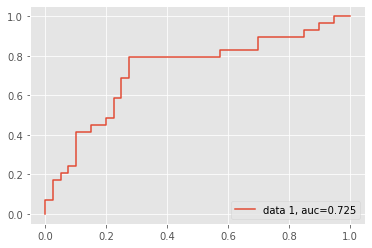

In [ ]:
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_test[:, 0], pred[:,0])
auc = metrics.roc_auc_score(y_test[:, 0], pred[:,0])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
X_test = []


# load the data from `df_test` (~ 1 minute)
for sample in tqdm(df_test["Sample ID"].values):
    _features = np.load(test_features_dir / sample)
    coordinates, features = _features[:, :3], _features[:, :]
    features1= np.insert(features,0,5, axis=1)
    X_test.append(features1)

X_test = np.array(X_test)

100%|██████████| 149/149 [00:09<00:00, 15.47it/s]


In [ ]:
X_test.shape

(149, 1000, 2052)

In [ ]:
X_test=X_test.reshape((149*1000,2052))
X_test = scaler.transform(X_test)
X_test=X_test.reshape((149,1000,2052))

In [ ]:
X_test = list(np.einsum("ij...->ji...", X_test))

In [ ]:
model = trained_models[0]
pred_test1 = model.predict(X_test)[:,0]

5/5 [==============================] - 83s 577ms/step


Repeat the 5 above cells two times. Change the center hopital to 2 and 5 to average the predictions.

In [ ]:
pred_test2 = model.predict(X_test)[:,0]

In [ ]:
pred_test3 = model.predict(X_test)[:,0]

In [ ]:
for i in range(149):
  for j in range(1000):
   X_test[j][i][0]=5
pred_test3 = model.predict(X_test)[:,0]

5/5 [==============================] - 3s 543ms/step


In [ ]:
del X_test

In [ ]:
pred_test1 = pred_test1*0.2 + pred_test2*0.2 + pred_test3*0.6

In [ ]:
submission = pd.DataFrame(
    {"Sample ID": df_test["Sample ID"].values, "Target": pred_test1}
).sort_values(
    "Sample ID"
)  # extra step to sort the sample IDs

# sanity checks
assert all(submission["Target"].between(0, 1)), "`Target` values must be in [0, 1]"
assert submission.shape == (149, 2), "Your submission file must be of shape (149, 2)"
assert list(submission.columns) == [
    "Sample ID",
    "Target",
], "Your submission file must have columns `Sample ID` and `Target`"

# save the submission as a csv file
submission.to_csv(data_dir / "benchmark_test_output_Pierre9.csv", index=None)
submission.head()

,Sample ID,Target
0,ID_003.npy,6.459200e-01
1,ID_004.npy,3.784551e-02
2,ID_008.npy,2.240446e-07
3,ID_009.npy,1.113684e-15
4,ID_010.npy,1.543451e-04
